# Requerimiento 4: Clustering Jerárquico de Artículos

## Descripción del Requerimiento

Este notebook implementa **clustering jerárquico aglomerativo** para agrupar artículos científicos según la similitud de sus abstracts.

### Objetivos:
1. Cargar y procesar abstracts de artículos desde archivo BibTeX
2. Limpiar y preprocesar texto eliminando stopwords y caracteres especiales
3. Vectorizar usando TF-IDF para representación numérica
4. Aplicar clustering jerárquico con diferentes métodos de enlace
5. Visualizar resultados mediante dendrogramas

### Algoritmos Implementados:
- **Single Linkage**: Distancia mínima entre clusters
- **Complete Linkage**: Distancia máxima entre clusters
- **Average Linkage**: Distancia promedio entre clusters

# 1.Importaciones

### Librerías Importadas

Esta celda carga todas las dependencias necesarias para el análisis:

**Procesamiento de Datos**:
- **bibtexparser**: Parsea archivos `.bib` y extrae metadatos bibliográficos
- **re**: Expresiones regulares para limpieza de texto

**Procesamiento de Lenguaje Natural**:
- **nltk**: Natural Language Toolkit para procesamiento de texto
- **stopwords**: Lista de palabras comunes sin valor semántico

**Machine Learning**:
- **TfidfVectorizer**: Convierte texto a vectores numéricos usando TF-IDF
  - **TF** (Term Frequency): Frecuencia de término en documento
  - **IDF** (Inverse Document Frequency): Importancia del término en el corpus

**Clustering y Distancias**:
- **pdist**: Calcula matriz de distancias entre todos los pares de documentos
- **linkage**: Implementa algoritmos de clustering jerárquico
- **dendrogram**: Genera visualización del árbol jerárquico

**Utilidades**:
- **numpy**: Operaciones matriciales y manejo de arrays
- **matplotlib**: Generación de gráficos y dendrogramas

In [1]:
# Importamos las librerías necesarias
import bibtexparser     # Permite leer y procesar archivos .bib (formato bibliográfico de referencias)
import re                   # Librería estándar para trabajar con expresiones regulares (búsqueda y reemplazo de patrones de texto)
import nltk                 # Natural Language Toolkit: herramienta para procesamiento de lenguaje natural
from nltk.corpus import stopwords  # Módulo para acceder a las palabras vacías ("stopwords")

# Esta herramienta convierte texto en vectores numéricos usando el modelo
# TF-IDF (Term Frequency – Inverse Document Frequency),
# que mide la relevancia de cada palabra en relación con todos los documentos.
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.spatial.distance import pdist        # Calcula las distancias entre cada par de documentos
from scipy.cluster.hierarchy import linkage, dendrogram  # Realiza el agrupamiento jerárquico y genera el dendrograma
import numpy as np                              # Para manejo de matrices y operaciones numéricas
import matplotlib.pyplot as plt                 # Para graficar los dendrogramas

# 2.Carga de Datos desde BibTeX

Esta celda realiza la extracción de abstracts y títulos del archivo consolidado.

#### Proceso de Carga:

**1. Configuración de Variables de Entorno**
```python
from dotenv import load_dotenv
ruta_bib = os.getenv("CONSOLIDADO_PATH", "../consolidado.bib")
```
- Carga ruta desde archivo `.env`
- Fallback a ruta relativa si no existe la variable

**2. Parsing con bibtexparser**
```python
bib_database = bibtexparser.load(bibtex_file)
```
- Convierte el archivo a estructura de datos Python
- Cada entrada es un diccionario con campos bibliográficos

**3. Extracción de campos**
- **abstract**: Resumen del artículo (texto principal para análisis)
- **title**: Título del artículo (para etiquetas en dendrograma)

**4. Muestreo de datos**
```python
abstracts_muestra = abstracts[:100]
```
- Se toman solo 100 artículos para visualización clara
- Con miles de artículos el dendrograma sería ilegible

#### Consideraciones sobre Tamaño de Muestra:

**Tamaño vs Legibilidad**:
- **100 artículos**: Dendrograma legible, análisis rápido
- **500+ artículos**: Dendrograma denso, análisis lento
- **1000+ artículos**: Dendrograma ilegible

**Alternativa de Muestreo Aleatorio**:
```python
import random
indices = random.sample(range(len(abstracts)), 100)
abstracts_muestra = [abstracts[i] for i in indices]
```

In [2]:
import os
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()

# Obtener ruta del archivo consolidado desde variable de entorno
ruta_bib = os.getenv("CONSOLIDADO_PATH", "../consolidado.bib")

# Verificar que el archivo existe
if not os.path.exists(ruta_bib):
    print(f"Error: No se encuentra el archivo en {ruta_bib}")
    raise FileNotFoundError(f"No se encuentra {ruta_bib}")

print(f"Leyendo archivo: {ruta_bib}")

# Se abre el archivo con codificación UTF-8 (para evitar errores de caracteres especiales)
# y se carga usando bibtexparser, que convierte el contenido en una estructura tipo diccionario.
with open(ruta_bib, encoding="utf-8") as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)

# Recorremos todas las entradas del archivo .bib
# y extraemos los campos "abstract" (resumen) y "title" (título).
abstracts = []
titulos = []
for entry in bib_database.entries:
    # Verificamos que la entrada tenga un resumen
    if "abstract" in entry:
        abstracts.append(entry["abstract"])                     # Guardamos el resumen
        titulos.append(entry.get("title", "Sin título"))        # Guardamos el título (o "Sin título" si no existe)

# Mostramos cuántos abstracts se encontraron en total
print(f"Total de abstracts encontrados: {len(abstracts)}")

# Para evitar problemas de rendimiento ya que el archivo tiene más de 10000 abstracts,
# se toma solo una muestra de los primeros 100 abstracts (para que se vea más bonito los dendogramas).
# Esto permite analizar un subconjunto representativo sin saturar la memoria.

if len(abstracts) > 100:
    abstracts_muestra = abstracts[:100]     # Toma los primeros 100 abstracts
    titulos_muestra = titulos[:100]         # Toma los títulos correspondientes
else:
    abstracts_muestra = abstracts           # Si hay menos de 100, usa todos
    titulos_muestra = titulos

# Mostramos cuántos abstracts se analizarán finalmente
print(f"Se analizarán los primeros {len(abstracts_muestra)} abstracts del archivo.")

Leyendo archivo: /home/nop/Documentos/proyectoAnalisisAlgoritmos/proyecto/salidas/consolidado.bib
Total de abstracts encontrados: 48
Se analizarán los primeros 48 abstracts del archivo.


# 3.Preprocesamiento de Texto

### Limpieza y Normalización de Texto

Esta celda prepara los abstracts para el análisis de clustering mediante limpieza y normalización.

#### Proceso de Preprocesamiento:

**1. Conversión a Minúsculas**
```python
texto = texto.lower()
```
- Normaliza el texto para que "Machine" y "machine" sean tratados igual

**2. Eliminación de Caracteres Especiales**
```python
texto = re.sub(r'[^a-z\s]', '', texto)
```
- Mantiene solo letras y espacios
- Elimina números, puntuación y símbolos

**3. Eliminación de Stopwords**
```python
palabras = [p for p in palabras if p not in stop_words]
```
- Remueve palabras comunes sin valor semántico (the, is, at, etc.)
- Reduce dimensionalidad y ruido en el análisis

**4. Reconstrucción del Texto**
```python
return ' '.join(palabras)
```
- Une las palabras filtradas en un string limpio

#### Importancia del Preprocesamiento:

**Sin Preprocesamiento**:
- "Machine Learning" y "machine-learning" serían términos diferentes
- Stopwords dominarían las frecuencias
- Puntuación generaría tokens inválidos

**Con Preprocesamiento**:
- Texto normalizado y consistente
- Enfoque en palabras con significado semántico
- Vectorización más efectiva

In [3]:
# Las stopwords son palabras muy comunes como "the", "and", "is", etc.
# que no aportan significado útil al análisis y se eliminan.
nltk.download('stopwords')

# Se obtiene el conjunto de palabras vacías en inglés
stop_words = set(stopwords.words("english"))


def limpiar_texto(texto):
    """
    Esta función limpia el texto de cada abstract para dejarlo listo
    para el análisis de similitud. Realiza varios pasos:
      1. Convierte el texto a minúsculas.
      2. Elimina todos los caracteres que no sean letras (como números o signos de puntuación).
      3. Separa las palabras (tokeniza de forma simple con split()).
      4. Elimina las stopwords y las palabras muy cortas (menores de 3 letras).
      5. Une las palabras limpias nuevamente en un solo texto.
    """
    #Convertir todo el texto a minúsculas
    texto = texto.lower()

    #Eliminar caracteres que no sean letras (mantiene solo a-z y espacios)
    texto = re.sub(r'[^a-z\s]', '', texto)

    #Dividir el texto en palabras individuales
    palabras = texto.split()

    #Eliminar stopwords y palabras muy cortas
    palabras = [w for w in palabras if w not in stop_words and len(w) > 2]

    #Volver a unir las palabras en un texto limpio
    return " ".join(palabras)

# Se recorre la lista de abstracts seleccionados (los primeros 100)
# y se aplica la función "limpiar_texto" a cada uno.
abstracts_limpios = [limpiar_texto(a) for a in abstracts_muestra]

# Se imprime un ejemplo de texto ya limpio (solo los primeros 300 caracteres)
print("Ejemplo de texto limpio:\n")
print(abstracts_limpios[0][:300])


Ejemplo de texto limpio:

light rapid unpredictable developments artificial intelligence growing need innovative marketing strategies expand market reach effectively promote services social interaction emerged powerful tools modern marketing particularly use social media platforms enhance product awareness drive customer eng


[nltk_data] Downloading package stopwords to /home/nop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 4.Conversión de Texto a Vectores TF-IDF

Esta celda transforma los abstracts preprocesados en vectores numéricos usando TF-IDF.

#### Fundamento Matemático:

**TF-IDF (Term Frequency - Inverse Document Frequency)**:

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$

Donde:
- **TF (Term Frequency)**: Frecuencia del término en el documento
  $$\text{TF}(t, d) = \frac{\text{count}(t, d)}{\text{total words in } d}$$

- **IDF (Inverse Document Frequency)**: Importancia del término en el corpus
  $$\text{IDF}(t) = \log\left(\frac{N}{\text{df}(t)}\right)$$
  - $N$: Total de documentos
  - $\text{df}(t)$: Número de documentos que contienen el término

**Intuición**:
- Palabras frecuentes en un documento pero raras en el corpus → **Alto TF-IDF** (relevantes)
- Palabras comunes en todos los documentos → **Bajo TF-IDF** (poco discriminativas)

#### Implementación con scikit-learn:

```python
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(abstracts_procesados)
```

**Parámetros**:
- `max_features=1000`: Limita a las 1000 palabras más relevantes
- `fit_transform()`: Aprende vocabulario y transforma documentos

**Salida**:
- Matriz dispersa de dimensiones `(n_documentos, n_features)`
- Cada fila es un documento representado como vector de pesos TF-IDF

#### Ventajas de TF-IDF:

- **Captura importancia relativa**: No solo frecuencia absoluta
- **Reduce ruido**: Palabras comunes tienen bajo peso
- **Eficiente**: Representación dispersa ahorra memoria
- **Estándar**: Ampliamente usado en NLP y clustering

In [4]:
# max_features = 1000 limita el número de palabras que se considerarán.
# Esto mejora el rendimiento y evita que la matriz sea demasiado grande.
# El vectorizador eliminará automáticamente las palabras muy poco frecuentes.
vectorizador = TfidfVectorizer(max_features=1000)

# El método fit_transform() realiza dos tareas:
#  1. Aprende el vocabulario y la importancia de cada palabra (fit)
#  2. Convierte cada abstract en un vector numérico (transform)
# Cada fila de la matriz resultante representa un abstract,
# y cada columna representa una palabra del vocabulario.
matriz_tfidf = vectorizador.fit_transform(abstracts_limpios)

# Se imprime la forma (filas, columnas) de la matriz:
# - Filas = cantidad de abstracts analizados
# - Columnas = cantidad de palabras consideradas (máximo 1000)
print(f"Matriz TF-IDF generada con forma: {matriz_tfidf.shape}")



Matriz TF-IDF generada con forma: (48, 1000)


# 5. Clustering Jerárquico con Tres Métodos de Enlace

Esta sección implementa clustering jerárquico usando tres métodos diferentes de enlace para comparar sus resultados.

## Fundamentos Matemáticos de los Métodos de Enlace

### **1. Enlace Simple (Single Linkage)**

La distancia entre dos clusters $C_i$ y $C_j$ se define como:

$$d(C_i, C_j) = \min_{x \in C_i, y \in C_j} d(x, y)$$

**Características**:
- Usa la distancia mínima entre cualquier par de puntos
- **Ventajas**: Detecta relaciones débiles entre artículos, útil para transiciones temáticas
- **Desventajas**: Efecto chaining (clusters alargados), sensible a outliers

---

### **2. Enlace Completo (Complete Linkage)**

La distancia entre dos clusters $C_i$ y $C_j$ se define como:

$$d(C_i, C_j) = \max_{x \in C_i, y \in C_j} d(x, y)$$

**Características**:
- Usa la distancia máxima entre cualquier par de puntos
- **Ventajas**: Clusters compactos y esféricos, robusto a outliers
- **Desventajas**: Puede ser muy conservador en las fusiones

---

### **3. Enlace Promedio (Average Linkage)**

La distancia entre dos clusters $C_i$ y $C_j$ se define como:

$$d(C_i, C_j) = \frac{1}{|C_i| \cdot |C_j|} \sum_{x \in C_i} \sum_{y \in C_j} d(x, y)$$

**Características**:
- Usa el promedio de todas las distancias entre pares de puntos
- **Ventajas**: Balance entre simple y completo, clusters equilibrados
- **Desventajas**: Mayor costo computacional

---

## Algoritmo de Clustering Jerárquico Aglomerativo

1. Inicialmente, cada documento es un cluster individual
2. En cada iteración:
   - Calcula distancias entre todos los pares de clusters según el método de enlace
   - Fusiona el par de clusters con menor distancia
   - Actualiza la matriz de distancias
3. Repite hasta tener un solo cluster que contiene todos los documentos

**Complejidad**: $O(n^2 \log n)$ con optimizaciones

---

## Implementación

El código siguiente genera un dendrograma para cada método, permitiendo visualizar cómo cada estrategia de enlace agrupa los artículos de manera diferente.


Generando dendrograma con método: SINGLE...


/tmp/ipykernel_63061/108001267.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


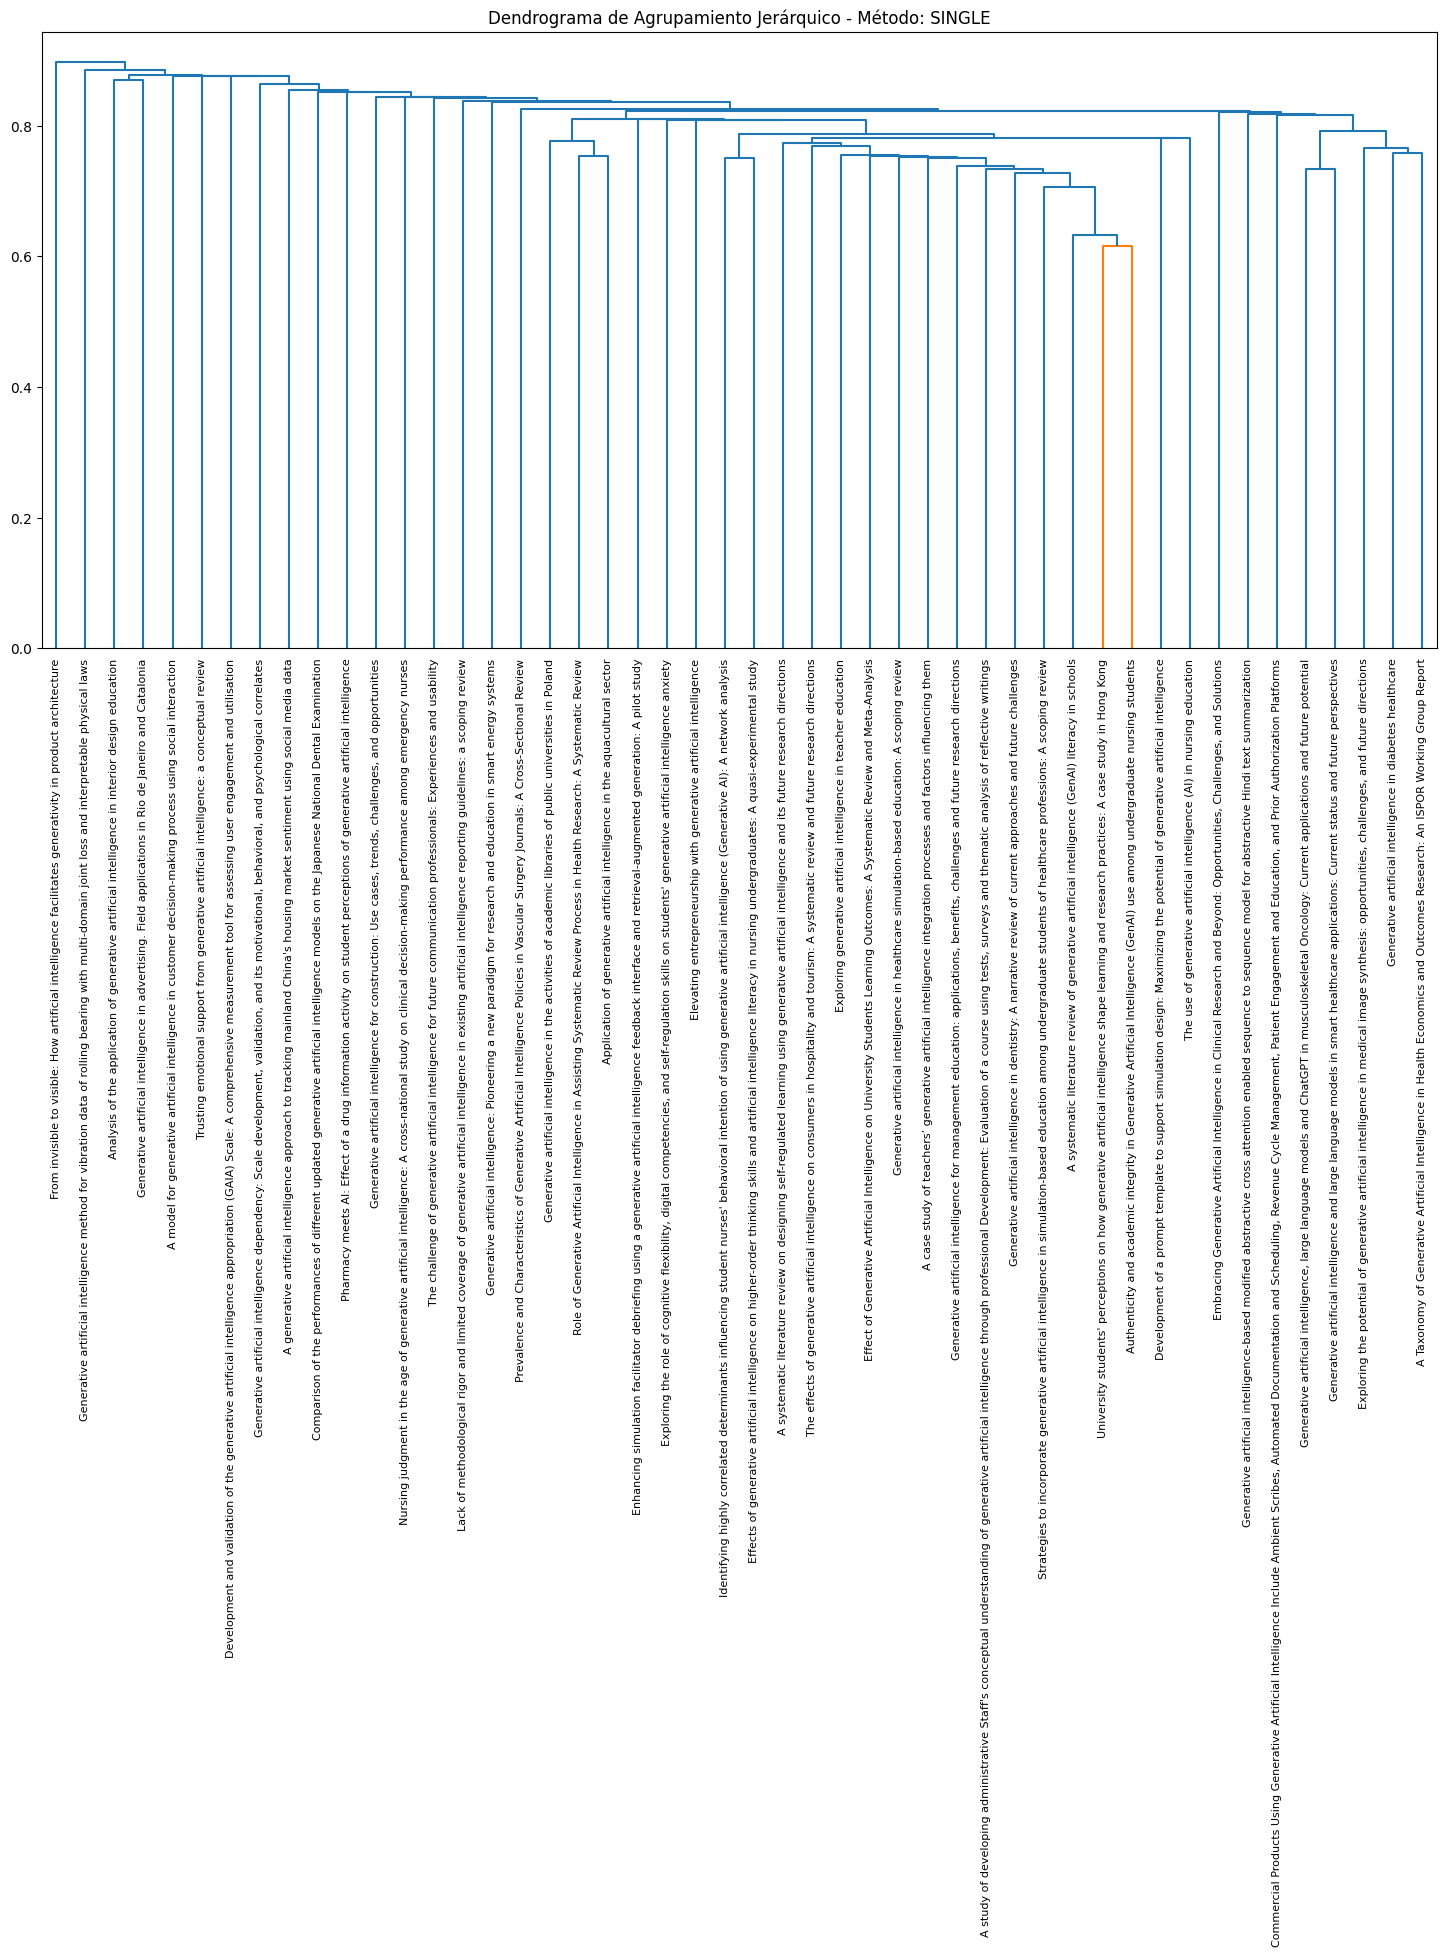


Generando dendrograma con método: COMPLETE...


/tmp/ipykernel_63061/108001267.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


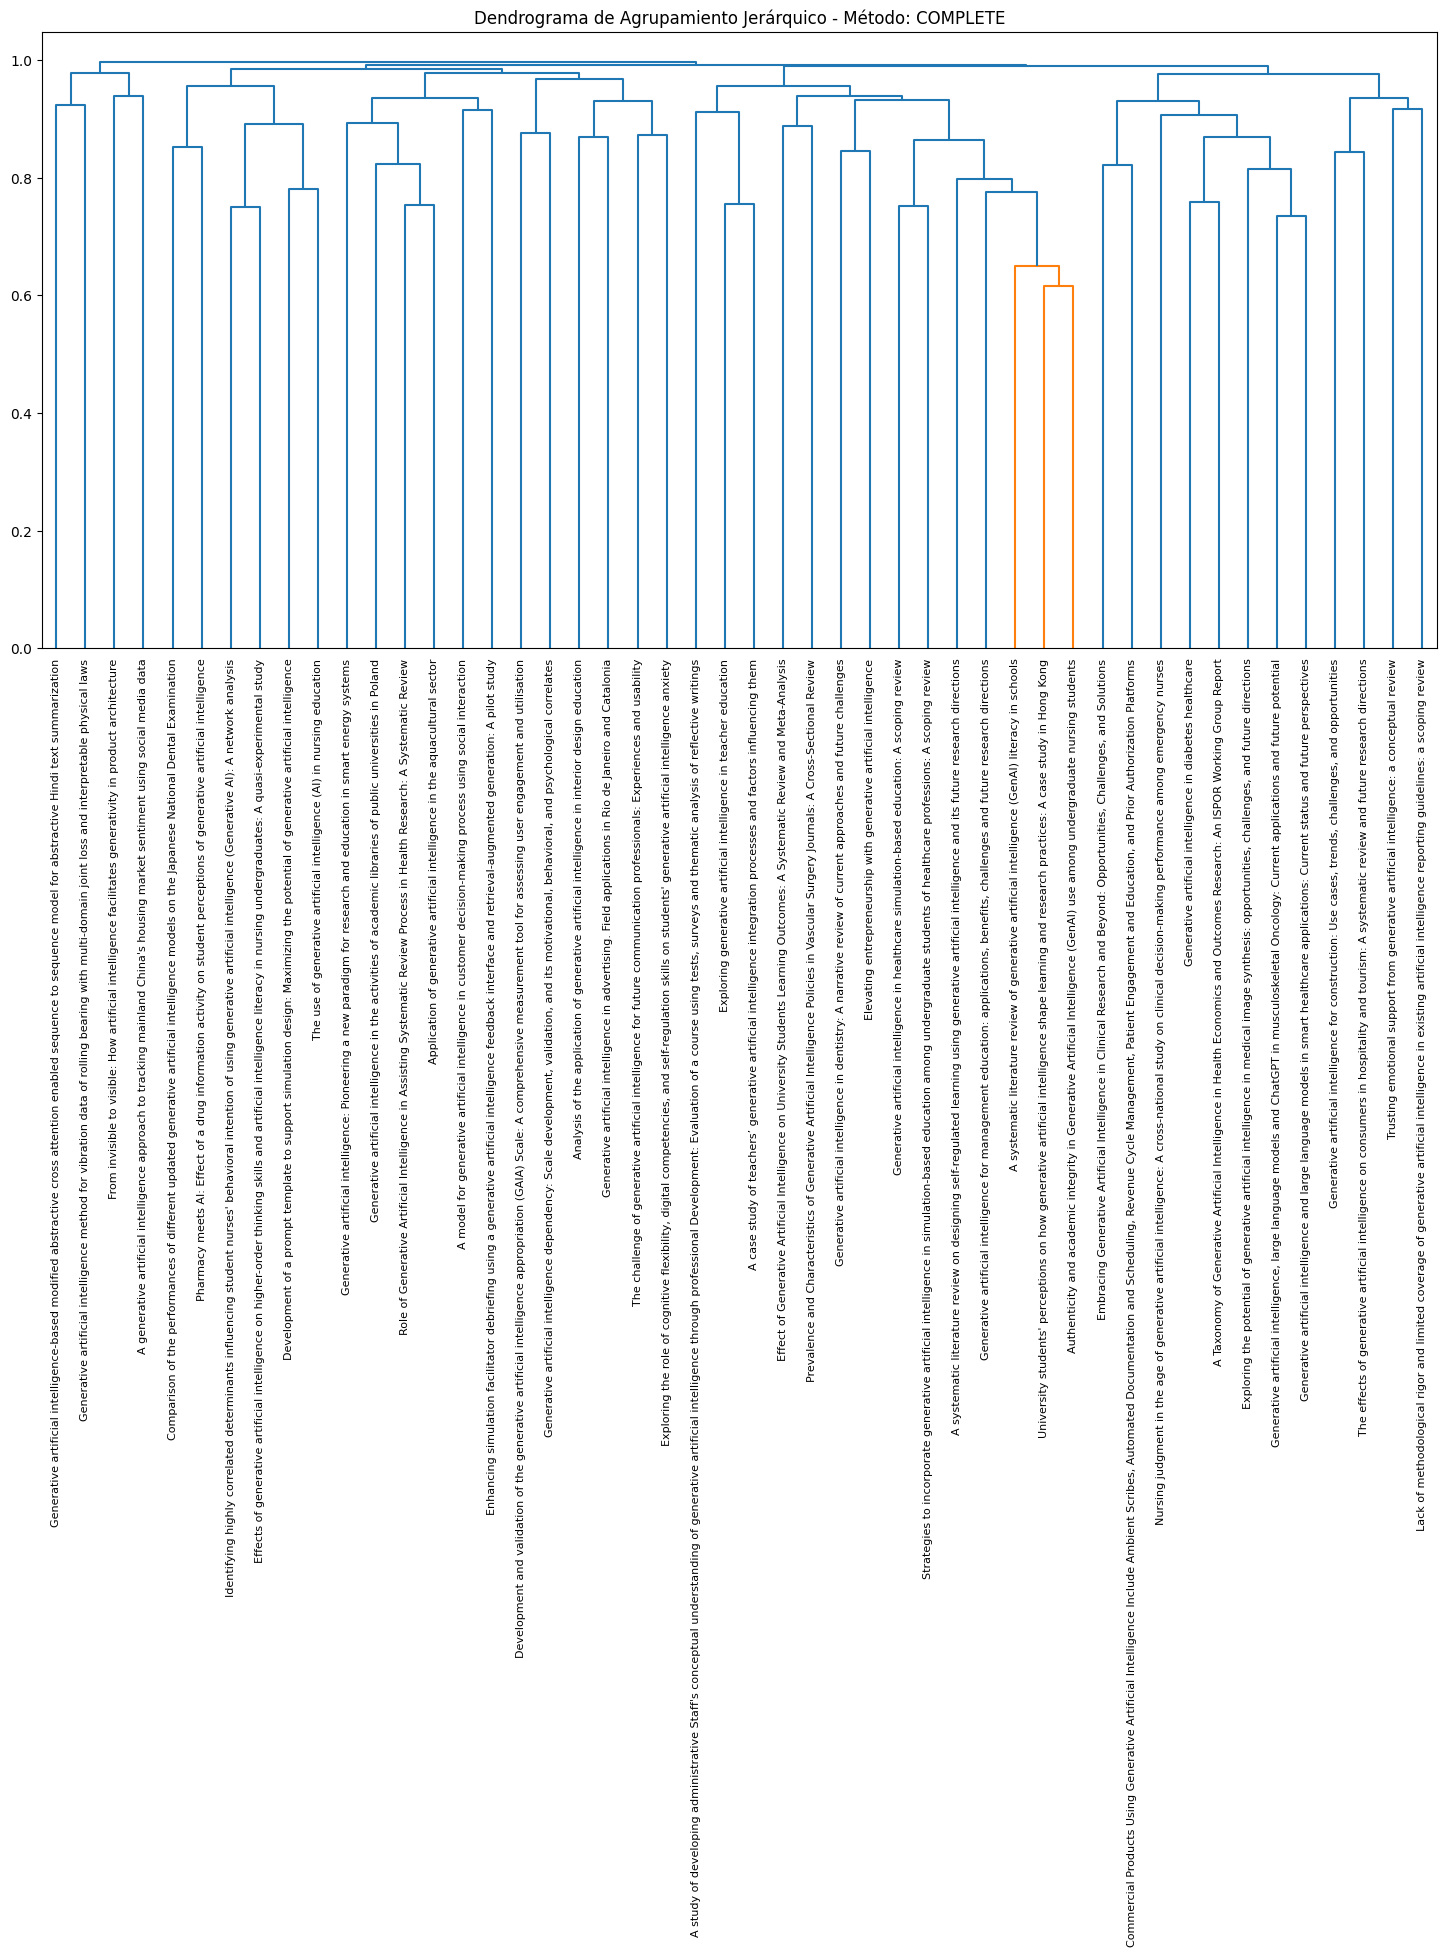


Generando dendrograma con método: AVERAGE...


/tmp/ipykernel_63061/108001267.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


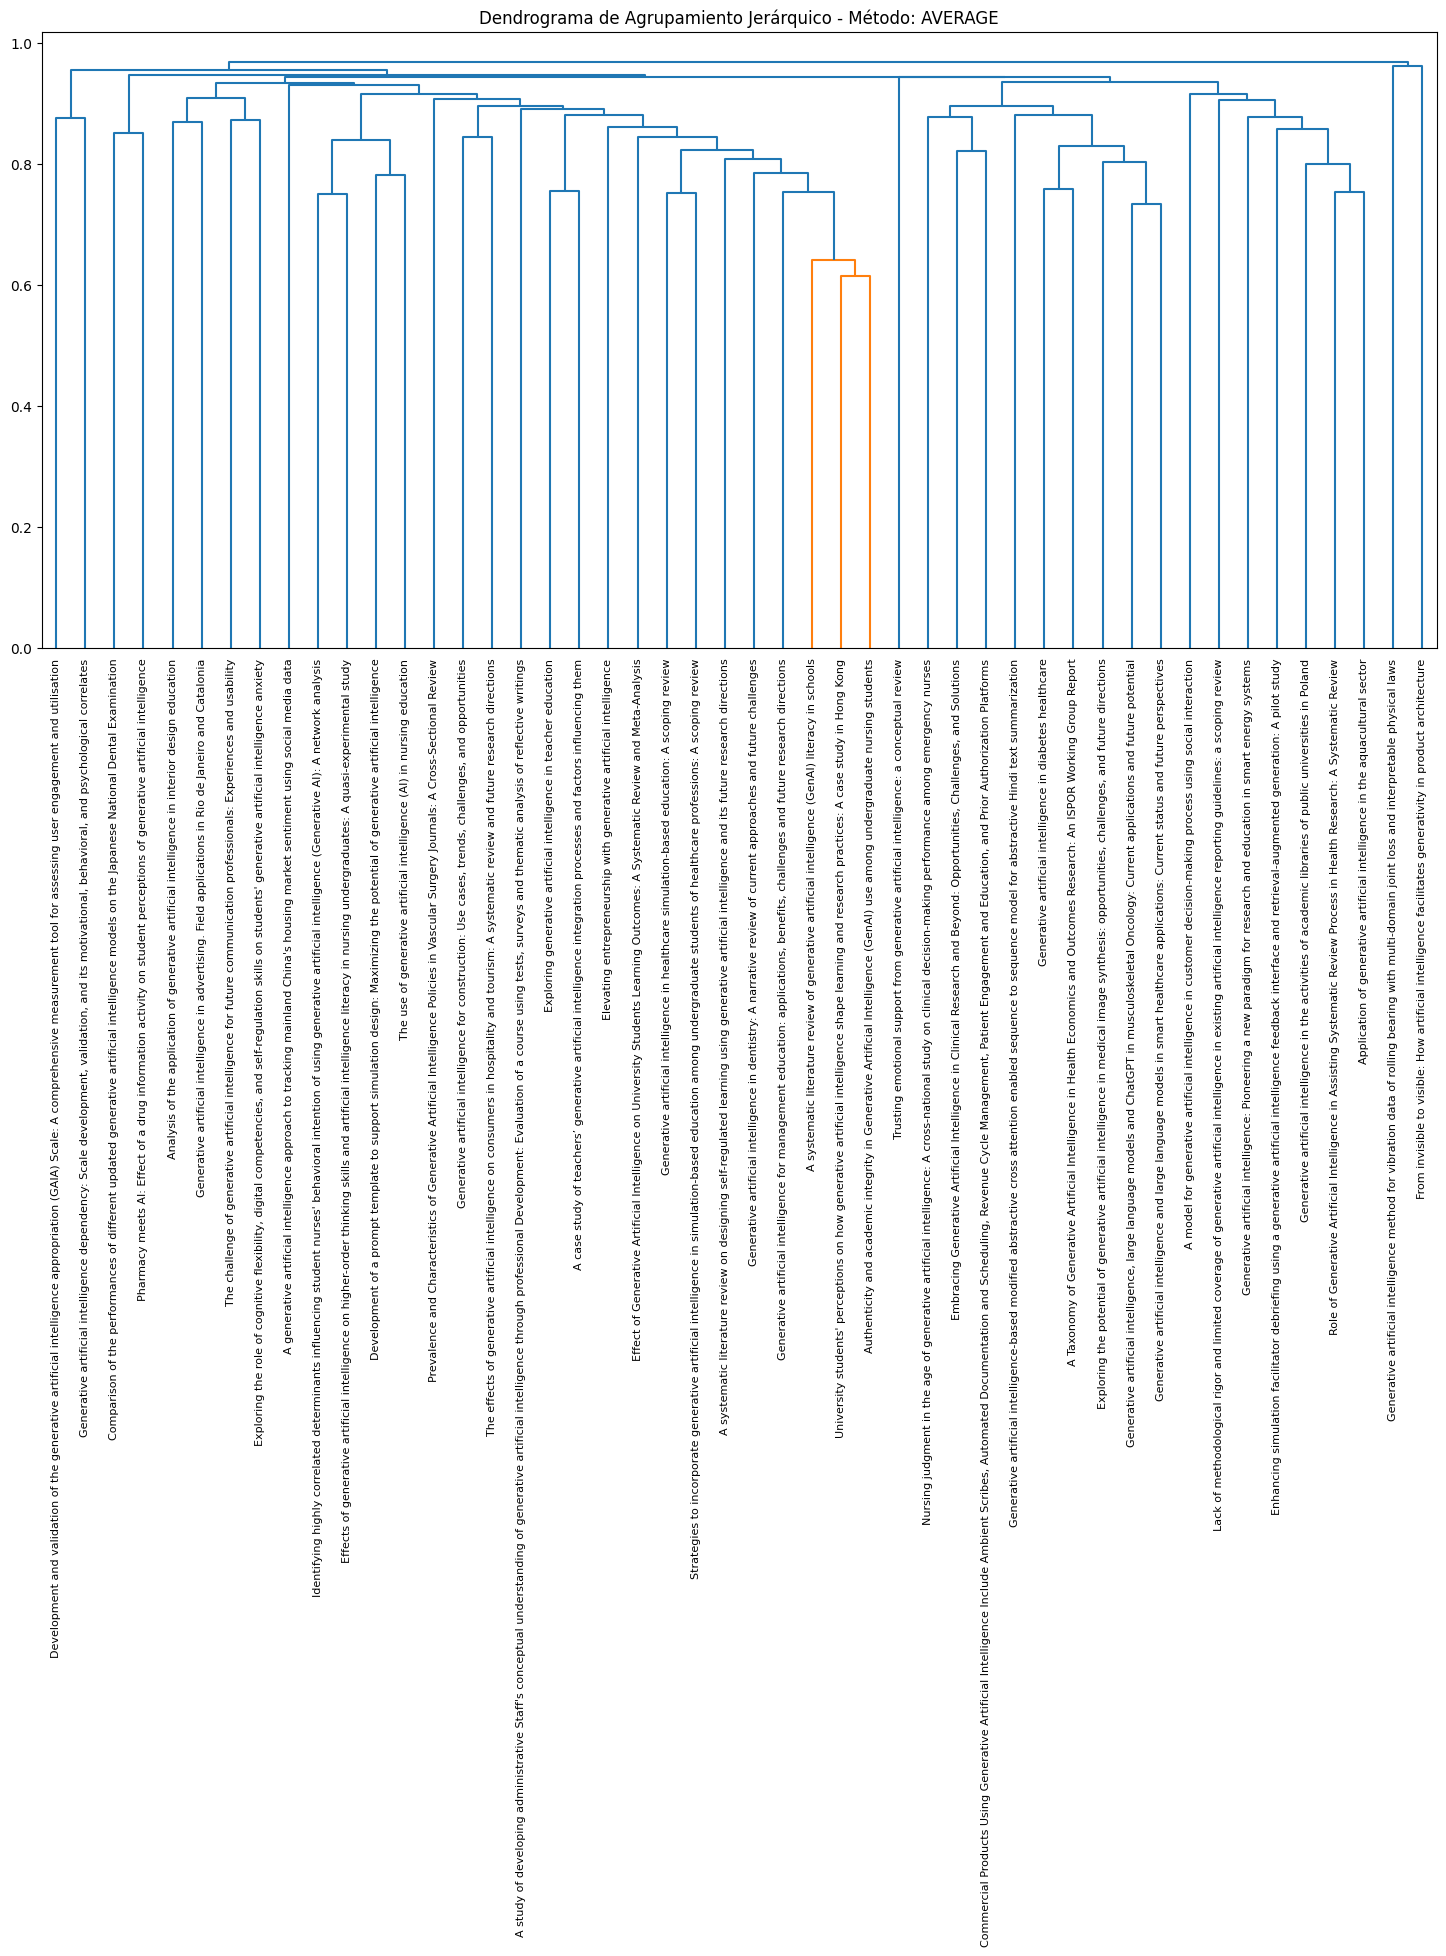

In [5]:
# Estos métodos determinan cómo se calcula la distancia entre grupos de documentos:
# - "single": usa la menor distancia entre dos puntos de diferentes clusters.
# - "complete": usa la mayor distancia entre dos puntos de diferentes clusters.
# - "average": usa el promedio de todas las distancias entre los puntos de los clusters.
metodos = ["single", "complete", "average"]


# Bucle principal para generar un dendrograma por cada método
for metodo in metodos:
    print(f"\nGenerando dendrograma con método: {metodo.upper()}...")

    # Se calcula la distancia entre cada par de abstracts usando la métrica del coseno.
    # La distancia coseno mide cuán similares son dos vectores TF-IDF:
    # - 0 → textos idénticos
    # - 1 → textos completamente diferentes
    dist_matrix = pdist(matriz_tfidf.toarray(), metric="cosine")

    # En algunos casos, la distancia coseno puede devolver valores NaN o infinitos
    # si hay vectores vacíos. np.nan_to_num() reemplaza esos valores por 0.
    dist_matrix = np.nan_to_num(dist_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    # linkage() usa la matriz de distancias para construir la jerarquía de agrupamiento.
    # - 'method' define cómo se unen los clusters (según el método actual del bucle).
    # - El resultado 'Z' es una matriz que describe las fusiones de clusters paso a paso.
    Z = linkage(dist_matrix, method=metodo)

    # Se genera un gráfico jerárquico que muestra la similitud entre los abstracts.
    # Cada "rama" representa un grupo de textos que comparten palabras y contexto similar.
    plt.figure(figsize=(18, 8))
    plt.title(f"Dendrograma de Agrupamiento Jerárquico - Método: {metodo.upper()}")
    dendrogram(Z, labels=titulos_muestra, leaf_rotation=90, leaf_font_size=8)
    plt.tight_layout()
    plt.show()


# 6. Comparación Visual de los Tres Métodos

Esta celda genera una visualización comparativa de los tres métodos de enlace en un solo gráfico.

## Objetivo

Facilitar la comparación directa de las estructuras jerárquicas generadas por cada método:
- **Single Linkage**: Tendencia al efecto cadena
- **Complete Linkage**: Clusters compactos y bien definidos  
- **Average Linkage**: Balance entre ambos extremos

## Visualización

Se muestran tres dendrogramas lado a lado sin etiquetas individuales (`no_labels=True`) para enfocarse en la estructura general.

**Parámetro `color_threshold=0.7`**:
- Define el nivel de corte para colorear clusters
- Ramas por debajo del umbral reciben colores distintos
- Facilita identificar grupos naturales

## Métricas de Comparación

Se calculan las **alturas máximas** de fusión para cada método:
- **Altura máxima**: Distancia a la que se fusionan los últimos dos clusters
- Valores más altos indican mayor disimilitud entre grupos principales
- Útil para determinar cuántos clusters naturales existen

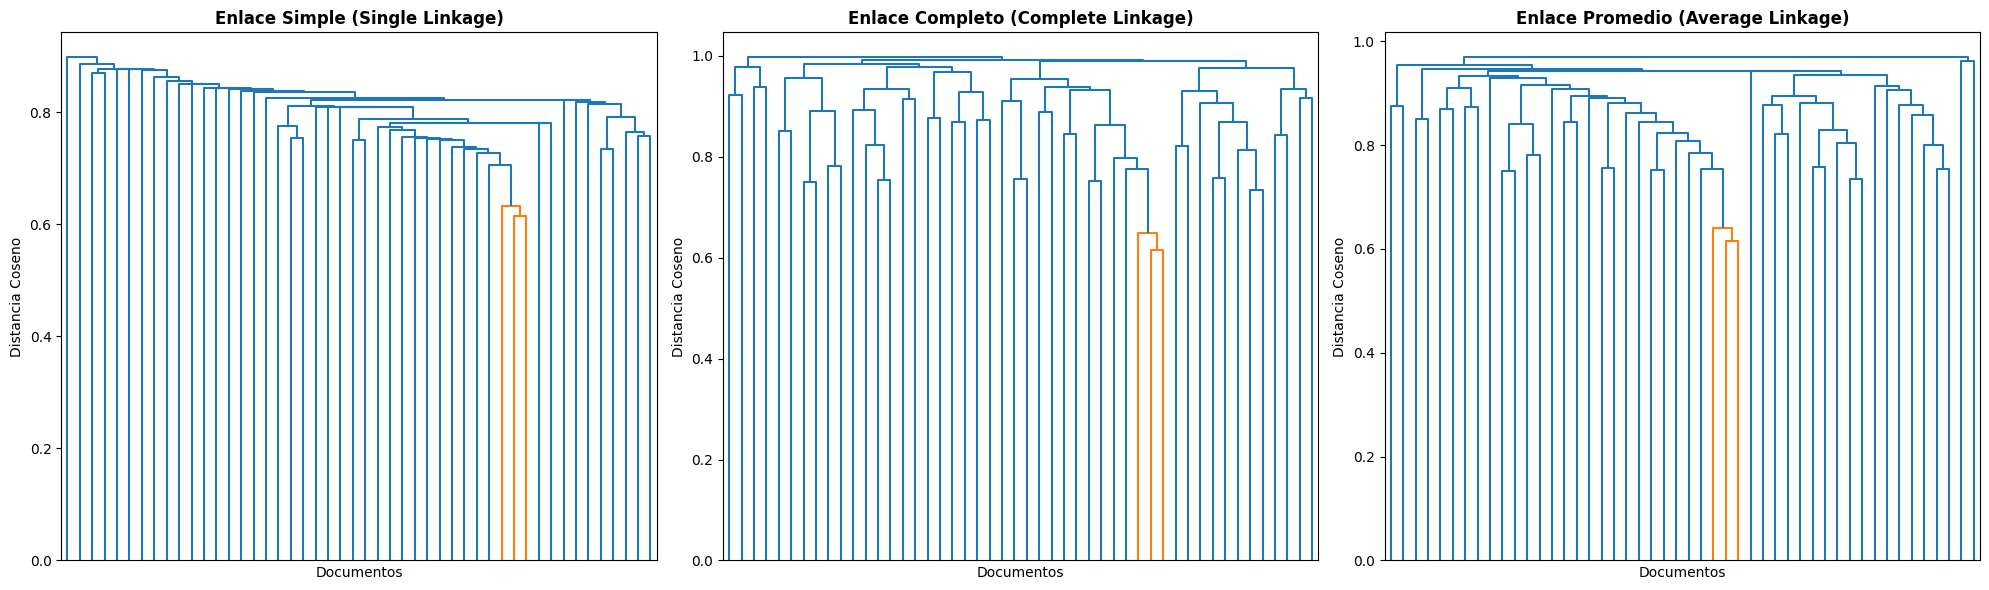


Comparacion de Metodos:
- Single Linkage: Altura maxima = 0.8980
- Complete Linkage: Altura maxima = 0.9970
- Average Linkage: Altura maxima = 0.9689


In [6]:
# Comparación visual de los tres métodos de enlace
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Calcular matrices de enlace para cada método
Z_single = linkage(pdist(matriz_tfidf.toarray(), metric="cosine"), method="single")
Z_complete = linkage(pdist(matriz_tfidf.toarray(), metric="cosine"), method="complete")
Z_average = linkage(pdist(matriz_tfidf.toarray(), metric="cosine"), method="average")

# Dendrograma para enlace simple
dendrogram(Z_single, ax=axes[0], no_labels=True, color_threshold=0.7)
axes[0].set_title('Enlace Simple (Single Linkage)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Documentos')
axes[0].set_ylabel('Distancia Coseno')

# Dendrograma para enlace completo
dendrogram(Z_complete, ax=axes[1], no_labels=True, color_threshold=0.7)
axes[1].set_title('Enlace Completo (Complete Linkage)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Documentos')
axes[1].set_ylabel('Distancia Coseno')

# Dendrograma para enlace promedio
dendrogram(Z_average, ax=axes[2], no_labels=True, color_threshold=0.7)
axes[2].set_title('Enlace Promedio (Average Linkage)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Documentos')
axes[2].set_ylabel('Distancia Coseno')

plt.tight_layout()
plt.show()

print("\nComparacion de Metodos:")
print(f"- Single Linkage: Altura maxima = {Z_single[:, 2].max():.4f}")
print(f"- Complete Linkage: Altura maxima = {Z_complete[:, 2].max():.4f}")
print(f"- Average Linkage: Altura maxima = {Z_average[:, 2].max():.4f}")

# 7. Evaluación Cuantitativa de Calidad del Clustering

Esta sección evalúa la calidad de los clusters formados usando métricas estándar de clustering.

## Métricas Implementadas

### **1. Coeficiente de Silueta (Silhouette Score)**

Mide qué tan bien está cada documento asignado a su cluster:

$$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$

Donde:
- $a(i)$: Distancia promedio de $i$ a otros puntos en su cluster (cohesión intra-cluster)
- $b(i)$: Distancia promedio de $i$ al cluster más cercano (separación inter-cluster)

**Interpretación**:
- $s \in [-1, 1]$
- $s \approx 1$: Documento bien asignado (alta cohesión, buena separación)
- $s \approx 0$: Documento en el borde entre clusters
- $s < 0$: Documento posiblemente mal asignado

**Criterio**: **Más alto es mejor**

---

### **2. Índice de Davies-Bouldin**

Evalúa la relación entre dispersión intra-cluster y separación inter-cluster:

$$DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{s_i + s_j}{d(c_i, c_j)} \right)$$

Donde:
- $s_i$: Dispersión promedio del cluster $i$
- $d(c_i, c_j)$: Distancia entre centroides de clusters $i$ y $j$

**Interpretación**:
- Valores más bajos indican mejor clustering
- Penaliza clusters dispersos y poco separados

**Criterio**: **Más bajo es mejor**

---

## Proceso de Evaluación

1. **Corte del dendrograma**: Se define `n_clusters=5` para obtener 5 grupos
2. **Asignación de etiquetas**: Usando `fcluster()` con criterio `maxclust`
3. **Cálculo de métricas**: Para cada método de enlace
4. **Comparación**: Identificar el mejor método según cada métrica

## Distribución de Documentos

También se analiza cómo se distribuyen los documentos entre clusters:
- Clusters balanceados indican agrupamiento equilibrado
- Clusters muy desbalanceados pueden indicar outliers o efecto cadena

In [7]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import fcluster

# Definir número de clusters para evaluación (corte del dendrograma)
n_clusters = 5

print("=" * 70)
print("EVALUACION DE CALIDAD DEL CLUSTERING")
print("=" * 70)
print(f"\nNumero de clusters evaluados: {n_clusters}\n")

# Evaluar cada método de enlace
metodos_eval = {
    "Single Linkage": Z_single,
    "Complete Linkage": Z_complete,
    "Average Linkage": Z_average
}

resultados = []

for nombre, Z in metodos_eval.items():
    # Obtener etiquetas de cluster cortando el dendrograma
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    
    # Calcular métricas
    silhouette = silhouette_score(matriz_tfidf.toarray(), labels, metric='cosine')
    davies_bouldin = davies_bouldin_score(matriz_tfidf.toarray(), labels)
    
    # Almacenar resultados
    resultados.append({
        'Método': nombre,
        'Silhouette': silhouette,
        'Davies-Bouldin': davies_bouldin,
        'Labels': labels
    })
    
    # Mostrar resultados
    print(f"{nombre}:")
    print(f"   - Coeficiente de Silueta: {silhouette:.4f}")
    print(f"   - Indice Davies-Bouldin: {davies_bouldin:.4f}")
    
    # Distribución de documentos por cluster
    unique, counts = np.unique(labels, return_counts=True)
    print(f"   - Distribucion de documentos: {dict(zip(unique, counts))}")
    print()

# Determinar el mejor método
print("=" * 70)
print("RESUMEN DE EVALUACION")
print("=" * 70)

# Mejor por Silhouette (más alto es mejor)
mejor_silhouette = max(resultados, key=lambda x: x['Silhouette'])
print(f"\nMejor Coeficiente de Silueta: {mejor_silhouette['Método']}")
print(f"   Valor: {mejor_silhouette['Silhouette']:.4f}")

# Mejor por Davies-Bouldin (más bajo es mejor)
mejor_db = min(resultados, key=lambda x: x['Davies-Bouldin'])
print(f"\nMejor Indice Davies-Bouldin: {mejor_db['Método']}")
print(f"   Valor: {mejor_db['Davies-Bouldin']:.4f}")

print("\n" + "=" * 70)

EVALUACION DE CALIDAD DEL CLUSTERING

Numero de clusters evaluados: 5

Single Linkage:
   - Coeficiente de Silueta: 0.0056
   - Indice Davies-Bouldin: 1.4329
   - Distribucion de documentos: {np.int32(1): np.int64(2), np.int32(2): np.int64(43), np.int32(3): np.int64(1), np.int32(4): np.int64(1), np.int32(5): np.int64(1)}

Complete Linkage:
   - Coeficiente de Silueta: 0.0363
   - Indice Davies-Bouldin: 3.4945
   - Distribucion de documentos: {np.int32(1): np.int64(4), np.int32(2): np.int64(6), np.int32(3): np.int64(12), np.int32(4): np.int64(14), np.int32(5): np.int64(12)}

Average Linkage:
   - Coeficiente de Silueta: 0.0177
   - Indice Davies-Bouldin: 1.6501
   - Distribucion de documentos: {np.int32(1): np.int64(2), np.int32(2): np.int64(2), np.int32(3): np.int64(42), np.int32(4): np.int64(1), np.int32(5): np.int64(1)}

RESUMEN DE EVALUACION

Mejor Coeficiente de Silueta: Complete Linkage
   Valor: 0.0363

Mejor Indice Davies-Bouldin: Single Linkage
   Valor: 1.4329



# 8. Visualización de Clusters en Espacio 2D

Esta celda proyecta los vectores TF-IDF de alta dimensión a un espacio 2D para visualizar los clusters formados.

## Reducción de Dimensionalidad con PCA

**PCA (Principal Component Analysis)** transforma los datos a un nuevo sistema de coordenadas donde:

$$\mathbf{Z} = \mathbf{X} \mathbf{W}$$

Donde:
- $\mathbf{X}$: Matriz de datos original (1000 dimensiones TF-IDF)
- $\mathbf{W}$: Matriz de componentes principales (vectores propios)
- $\mathbf{Z}$: Datos proyectados (2 dimensiones)

**Componentes Principales**:
- **PC1**: Dirección de máxima varianza en los datos
- **PC2**: Segunda dirección de máxima varianza (ortogonal a PC1)

## Ventajas de la Visualización 2D

1. **Intuición visual**: Permite ver la separación entre clusters
2. **Validación**: Confirma si los clusters tienen sentido geométricamente
3. **Detección de outliers**: Puntos aislados son fácilmente identificables
4. **Comparación de métodos**: Ver cómo cada método agrupa los datos

## Limitaciones

- **Pérdida de información**: Solo se preserva una fracción de la varianza total
- **Distorsión**: Las distancias en 2D no reflejan exactamente las distancias en 1000D
- **Interpretación**: La separación visual puede no corresponder a la separación real

## Varianza Explicada

Se reporta el porcentaje de varianza capturado por PC1 y PC2:
- Valores bajos (< 10%) son comunes en datos de alta dimensión como TF-IDF
- Indica que los datos tienen estructura compleja en muchas dimensiones

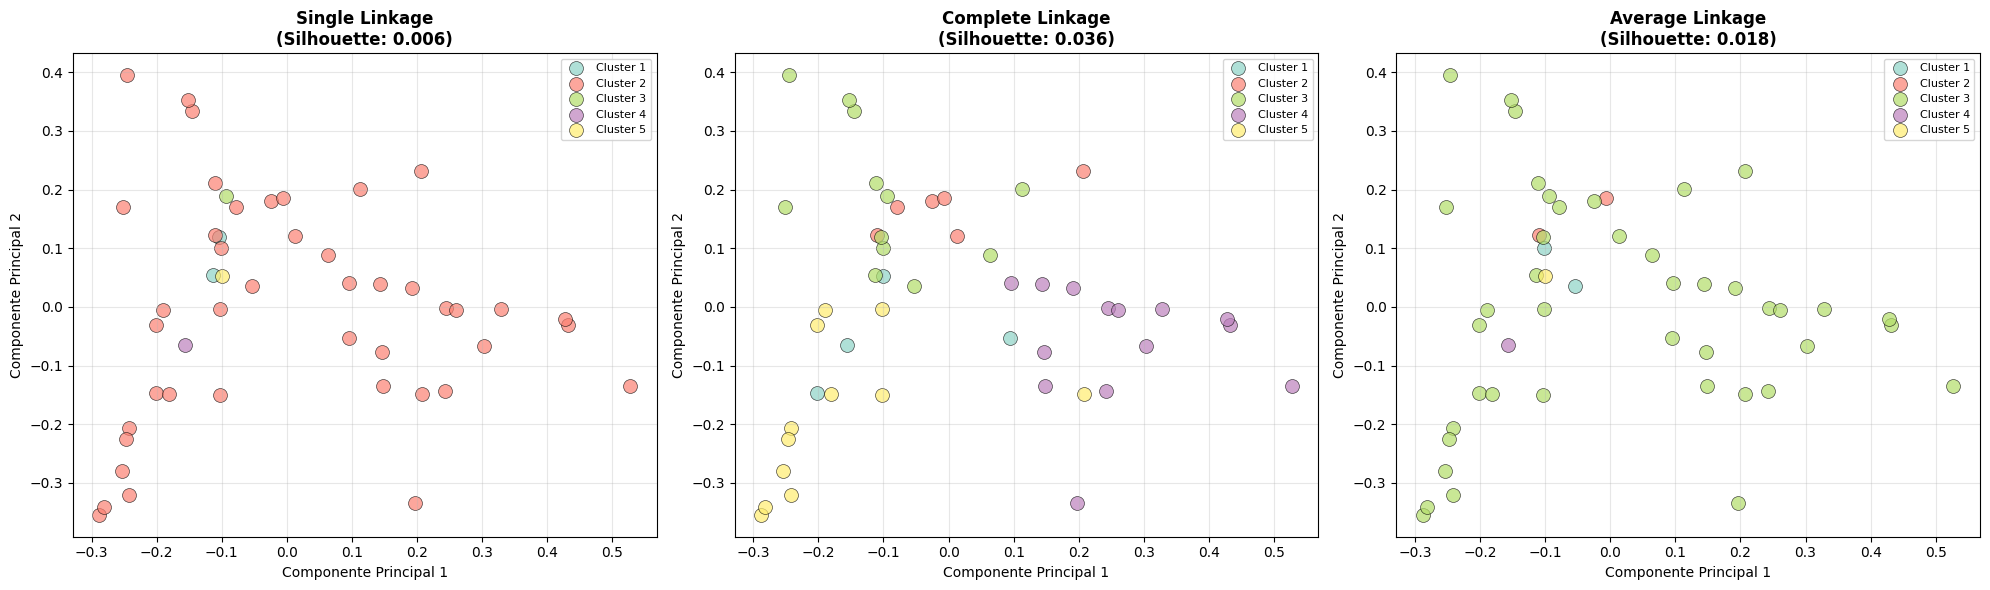


Varianza Explicada por PCA:
   - PC1: 4.92%
   - PC2: 3.56%
   - Total: 8.48%

Nota: Solo se visualiza 8.48% de la varianza total.


In [8]:
from sklearn.decomposition import PCA

# Reducir dimensionalidad a 2D para visualización
pca = PCA(n_components=2, random_state=42)
coordenadas_2d = pca.fit_transform(matriz_tfidf.toarray())

# Crear visualización para cada método
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

colores = plt.cm.Set3(np.linspace(0, 1, n_clusters))

for idx, resultado in enumerate(resultados):
    ax = axes[idx]
    labels = resultado['Labels']
    
    # Graficar cada cluster con un color diferente
    for cluster_id in range(1, n_clusters + 1):
        mask = labels == cluster_id
        ax.scatter(
            coordenadas_2d[mask, 0],
            coordenadas_2d[mask, 1],
            c=[colores[cluster_id - 1]],
            label=f'Cluster {cluster_id}',
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5
        )
    
    ax.set_title(f'{resultado["Método"]}\n(Silhouette: {resultado["Silhouette"]:.3f})', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Componente Principal 1', fontsize=10)
    ax.set_ylabel('Componente Principal 2', fontsize=10)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar varianza explicada por PCA
print(f"\nVarianza Explicada por PCA:")
print(f"   - PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   - PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"   - Total: {pca.explained_variance_ratio_.sum():.2%}")
print(f"\nNota: Solo se visualiza {pca.explained_variance_ratio_.sum():.2%} de la varianza total.")

# 9. Análisis de Palabras Clave por Cluster

Esta sección identifica las palabras más representativas de cada cluster para interpretar su temática.

## Metodología

### **1. Cálculo del Centroide**

Para cada cluster, se calcula el centroide como el promedio de los vectores TF-IDF:

$$\mathbf{c}_k = \frac{1}{|C_k|} \sum_{i \in C_k} \mathbf{x}_i$$

Donde:
- $\mathbf{c}_k$: Centroide del cluster $k$
- $C_k$: Conjunto de documentos en el cluster $k$
- $\mathbf{x}_i$: Vector TF-IDF del documento $i$

### **2. Extracción de Palabras Clave**

Se seleccionan las palabras con mayor peso TF-IDF en el centroide:

```python
top_indices = centroide.argsort()[-10:][::-1]
```

Estas palabras representan los términos más característicos del cluster.

## Interpretación de Resultados

### **Palabras Clave**
- Revelan la temática principal de cada cluster
- Permiten etiquetar clusters con nombres descriptivos
- Facilitan la validación semántica del clustering

### **Documentos de Ejemplo**
- Se muestran los primeros caracteres de algunos documentos
- Confirman que los documentos comparten temática
- Ayudan a entender el contexto de las palabras clave

## Aplicaciones

1. **Organización de literatura**: Agrupar artículos por tema
2. **Descubrimiento de tópicos**: Identificar áreas de investigación
3. **Recomendación**: Sugerir artículos similares
4. **Resumen**: Generar descripciones automáticas de colecciones

In [9]:
# Usar el mejor método según Silhouette Score
mejor_metodo = mejor_silhouette['Método']
mejor_labels = mejor_silhouette['Labels']

print("=" * 70)
print(f"ANALISIS DE PALABRAS CLAVE - {mejor_metodo}")
print("=" * 70)

# Obtener nombres de características (palabras)
feature_names = vectorizador.get_feature_names_out()

# Convertir matriz TF-IDF a array denso
matriz_densa = matriz_tfidf.toarray()

# Analizar cada cluster
for cluster_id in range(1, n_clusters + 1):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*70}")
    
    # Obtener documentos del cluster
    mask = mejor_labels == cluster_id
    docs_cluster = matriz_densa[mask]
    
    print(f"Numero de documentos: {docs_cluster.shape[0]}")
    
    # Calcular centroide del cluster (promedio de vectores TF-IDF)
    centroide = docs_cluster.mean(axis=0)
    
    # Obtener índices de las palabras con mayor peso en el centroide
    top_indices = centroide.argsort()[-10:][::-1]
    
    # Mostrar top 10 palabras clave
    print(f"\nTop 10 Palabras Clave:")
    for i, idx in enumerate(top_indices, 1):
        palabra = feature_names[idx]
        peso = centroide[idx]
        print(f"   {i:2d}. {palabra:20s} (TF-IDF: {peso:.4f})")
    
    # Mostrar algunos documentos de ejemplo del cluster
    indices_docs = np.where(mask)[0][:3]  # Primeros 3 documentos
    print(f"\nDocumentos de ejemplo:")
    for i, doc_idx in enumerate(indices_docs, 1):
        # Mostrar primeras 100 caracteres del documento
        doc_preview = abstracts_muestra[doc_idx][:100].replace('\n', ' ')
        print(f"   {i}. Doc {doc_idx}: {doc_preview}...")

print(f"\n{'='*70}")
print("FIN DEL ANALISIS")
print(f"{'='*70}")

ANALISIS DE PALABRAS CLAVE - Complete Linkage

CLUSTER 1
Numero de documentos: 4

Top 10 Palabras Clave:
    1. sentiment            (TF-IDF: 0.1678)
    2. sequence             (TF-IDF: 0.1315)
    3. sales                (TF-IDF: 0.1145)
    4. rolling              (TF-IDF: 0.1119)
    5. generativity         (TF-IDF: 0.1051)
    6. bearing              (TF-IDF: 0.0994)
    7. product              (TF-IDF: 0.0877)
    8. model                (TF-IDF: 0.0869)
    9. intelligent          (TF-IDF: 0.0865)
   10. data                 (TF-IDF: 0.0855)

Documentos de ejemplo:
   1. Doc 5: Abstractive Text summarization is the process of providing a concise as well as cohesive summary, wh...
   2. Doc 7: The prediction and health management (PHM) of rolling bearings have evolved toward data-driven trans...
   3. Doc 23: Artificial intelligence (AI) reshapes the business landscape. The role of AI applications in product...

CLUSTER 2
Numero de documentos: 6

Top 10 Palabras Clave:
    1. nur